# Post-processing simulation using Kuibit 

**General structure**:

- Import libraries
- Load simulation directory
    - Print all files
- Print Simulation info    
    - Extract available iterations: 
    
             `sim.gf.xyz['kxx'].available_iterations`
    
    - Define `avail_iter_max = avail_iter[-1]`
    - Define `diter = avail_iter[1]-avail_iter[0]`
    - Define `t` and `dt` from cctk_time
    - Define $\delta_{OD, IN}$
- Define Hamiltonian and Momentum average timeseries 

- Define GridFunctions for all available variables: 
    - Matter density `rho`
    - Extrinsic curvature `kxx` 
    - Trace of K `trK`
    - Spatial metric `gxx`
    - Determinant of g `detg`
    - Ricci tensor `Ricci11`
    - Ricci scalar `Ricci`

- Plot Hamiltonian and Momentum timeseries
    - Maybe discard some of the final iterations 

- Define corresponding background quantities (FLRW flat dust model or EdS)
    - Definitions from **ICCalc.F90**: $s=aa/a0$, $H$, $\Omega_m$
        - $\bar{K}=-3K$
        - $\bar{\gamma}=a^6$
        - $\bar{\rho}=3H^2 \Omega_m/\kappa$

    - Definitions from Robyn for $\Lambda=0$ (Validate!)
        - I think the formulas for FLRW are still valid here, and we just need to change: 
            - $s=\left(\frac{\tau}{\tau_0}\right)^{2/3}$
            - $H=\frac{2}{3\tau}$
            - $\Omega_m=1.0$    

- Check synchronization and define a coarse scale factor `aa_co` from timeseries, avail_iter_max and diter.
 
- Calculate redshift $z$ from coarse scale factor $a(\tau)$  

- Calculate density contrast, extrinsic curvature contrast, metric contrast     
    - Plot curves at the underdensity, underdensity and center of the box 
    - Plot outer and inner surfaces for the density contrast 
    - Try and do a 3D animation with isosurfaces of the density contrast at $z_{IN}$ to show:
        1. Spherical symmetry near to OD
        2. Filamentary-like structures
        3. Periodic Boundary conditions
        4. compensated inhomogeneity (just one lambda, linear average vanishes)

In [1]:
# Use et2 for compatibility
from kuibit.simdir import SimDir
import kuibit.visualize_matplotlib as viz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

# set plot theme 
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')

In [2]:
#pathtosimdir = '/home/jorge/Downloads/output-0000/testPert32_D'
#pathtosimdir = '/home/jorge/Downloads/output-0000/testPert32_E'
#pathtosimdir = '/home/jorge/Downloads/output-0000/testPert32_F'
#pathtosimdir = '/home/jorge/Downloads/output-0000/testPert32_G'
pathtosimdir = '/home/jorge/Downloads/output-0000/testPert32_H'
#pathtosimdir = '/home/jorge/Downloads/output-0000/testPert32_I'

sim = SimDir(pathtosimdir) 
print(sim)

Indexed 34 files and 1 subdirectories
Folder /home/jorge/Downloads/output-0000/testPert32_H
/home/jorge/Downloads/output-0000/testPert32_H
Available scalar timeseries:
[]

Available minimum timeseries:
[]

Available maximum timeseries:
[]

Available norm1 timeseries:
[]

Available norm2 timeseries:
[]

Available average timeseries:
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'alp', 'H', 'rho', 'betax', 'betay', 'betaz', 'M1', 'M2', 'M3']
Variables available: dict_keys([])

Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
[]


Available grid data of dimension 2D (xz): 
[]


Available grid data of dimension 2D (yz): 
[]


Available grid data of dimension 3D (xyz): 
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'Ricci11', 'Ricci12', 'Ricci13', 'Ricci22', 'Ricci23', 'Ricci33', 'Ricci', 'trK', 'detg', 'NaNmask', 'rho', '

In [3]:
# Available iterations and box size

box = int(pathtosimdir[-4:-2])
p = box//4        # OD index          
avail_iter = sim.gf.xyz['gxx'].available_iterations 
avail_iter_max = avail_iter[-1]
diter = avail_iter[1]-avail_iter[0]
print(f'Box size   = {box}')
print(f'Avail iter = {sim.gf.xyz['gxx'].available_iterations[:3]} ... {sim.gf.xyz['kxx'].available_iterations[-3:]}')

Box size   = 32
Avail iter = [0, 80, 160] ... [22000, 22080, 22160]


In [4]:
# Hamiltonian and momentum timeseries

M1 = sim.timeseries.average['M1']
M2 = sim.timeseries.average['M2']
M3 = sim.timeseries.average['M3']
H  = sim.timeseries.average['H']

# Grid functions

## Extrinsic curvature and spatial metric
kxx, gxx = sim.gf.xyz['kxx'], sim.gf.xyz['gxx']     # sim.gf.dim['var'][iteration]
kxy, gxy = sim.gf.xyz['kxy'], sim.gf.xyz['gxy']
kxz, gxz = sim.gf.xyz['kxz'], sim.gf.xyz['gxz']
kyy, gyy = sim.gf.xyz['kyy'], sim.gf.xyz['gyy']
kyz, gyz = sim.gf.xyz['kyz'], sim.gf.xyz['gyz']
kzz, gzz = sim.gf.xyz['kzz'], sim.gf.xyz['gzz']

## Ricci tensor and Ricci scalar
Rxx, Ryy, Rzz = sim.gf.xyz['Ricci11'], sim.gf.xyz['Ricci22'], sim.gf.xyz['Ricci33']
Rxy, Rxz = sim.gf.xyz['Ricci12'], sim.gf.xyz['Ricci13']
Ryz = sim.gf.xyz['Ricci23']
R = sim.gf.xyz['Ricci']

## Matter density, trace of K, determinant of g
rho = sim.gf.xyz['rho']
trk = sim.gf.xyz['trK']
detg= sim.gf.xyz['detg'] 

In [5]:
from localutils import delta_ini

delta_ini(sim, p)

0.04020930521645538

In [6]:
# Sanity Check: Ricci scalar at OD and UD, at z_IN

print(max(R[0][0][0][:,:,:].flatten()), min(R[0][0][0][:,:,:].flatten()))
print(R[0][0][0][p,p,p], R[0][0][0][-p,-p,-p])

0.17553135533200542 -0.16463221021492586
0.17553135533200542 -0.16463221021492586


In [ ]:
# Background quantities

# cctk time
t = np.array(M1.x)  

# Constants
G=1.
kappa = 8. * np.pi * G
Omega_matter0 = 0.3147                
Omega_lambda0 = 1. - Omega_matter0
ICPertFLRW_h = 0.6737                   # Dimenstionless hubble parameter
z_comoving_ref = 0.
a0 = 1. + z_comoving_ref                # Comoving reference redshift: a_0= 1+z_comoving_ref
H0 = ICPertFLRW_h * 1. / 2997.9         # Mpc
t0_EdS= 2. / ( 3. * H0 )                # Used for both models
    
# Actual calculations (ICCalc.F90 and param.ccl)
def a_factor(t):
    scale_factor = a0 * (Omega_matter0 / Omega_lambda0 )**(1./3.)*\
        (np.sinh( np.sqrt(Omega_lambda0) * t / t0_EdS ) ** (2./3.))
    return scale_factor  

aa = a_factor(t)
Hprop = H0 * np.sqrt(Omega_matter0 * ( aa / a0 )**(-3.) + Omega_lambda0)
Omega_matter = Omega_matter0 / ( Omega_matter0 + Omega_lambda0 * ( aa / a0 )**3.) 
rhoflrw = 3. * Hprop**2. * Omega_matter / kappa

In [ ]:
# Synchornize timeseries and grid functions

t.shape
t_co = t[:avail_iter_max+1:diter]
aa_co = a_factor(t_co)

In [26]:
# Coarse Redshift

def z_coarse(a):
    return 1/a - 1

z_co = z_coarse(aa_co)

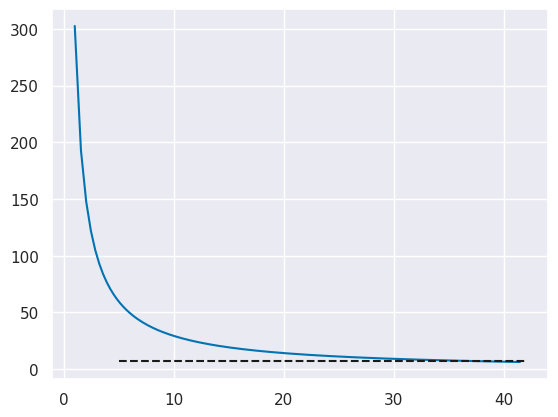

In [32]:
plt.plot(aa_co/aa_co[0], z_co)
plt.hlines(y=7.6234, xmin=5, xmax=42, linestyle='--', color='k')

In [33]:
# Matter density contrast, volume contrast, expansion contrast
# Ricci scalar and trace of K
# At the OD, UD and CT

rhoflrw_co = rhoflrw[:avail_iter_max+1:diter]
H_coarse = Hprop[:avail_iter_max+1:diter]

## Matter density contrast
deltarho_OD = [rho[i][0][0][8, 8, 8] for i in range(0, 39921, 80)]/rhoflrw_co 
deltarho_UD = [rho[i][0][0][-8, -8, -8] for i in range(0, 39921, 80)]/rhoflrw_co 
deltarho_CT = [rho[i][0][0][16, 16, 16] for i in range(0, 39921, 80)]/rhoflrw_co 

## Ricci
R_OD = np.array([R[i][0][0][  p,  p,  p] for i in range(0, avail_iter_max, diter)])
R_UD = np.array([R[i][0][0][ -p, -p, -p] for i in range(0, avail_iter_max, diter)])
R_CT = np.array([R[i][0][0][2*p,2*p,2*p] for i in range(0, avail_iter_max, diter)])

## Trace of K
trk_OD = np.array([trk[i][0][0][ 8, 8, 8] for i in avail_iter])/(-3.0*H_coarse) - 1.0
trk_UD = np.array([trk[i][0][0][-8,-8,-8] for i in avail_iter])/(-3.0*H_coarse) - 1.0
trk_CT = np.array([trk[i][0][0][16,16,16] for i in avail_iter])/(-3.0*H_coarse) - 1.0

NameError: name 'rhoflrw' is not defined

In [ ]:
# Plots

ind = 0
x = aa_ls/aa_ls[0] 
plt.plot(x,ud_list[ind:]/rhoflrw[::80][ind:] -1, label='UD')
plt.plot(x,od_list[ind:]/rhoflrw[::80][ind:]- 1, label='OD')
plt.plot(x,ct_list[ind:]/rhoflrw[::80][ind:] -1, label='CT')
plt.legend()
#plt.xlabel('cctk time')
plt.xlabel(r'$a/a_{\text{IN}}$')
plt.title(r'$\delta_{OD} \text{ and } \delta_{UD} $')
plt.annotate(
    'A_pert=7.5e-4\nlambda_pert=640',  # Annotation text
    xy=(5, 3.5),     # Point being annotated (arrow target)
    xytext=(8, 3.5), # Position of the text
    #arrowprops=dict(facecolor='black', shrink=0.05), # Arrow properties
    ha='center'    # Horizontal alignment of the text
)

# Contributions to the Raychaudhuri equation